In [36]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
# plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

### 데이터 불러오기

In [37]:
df = pd.read_csv('../Pizza Sales Dataset.csv')
df

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_day,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,Thursday,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,Thursday,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,Thursday,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,Thursday,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,Thursday,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,12/31/2015,Thursday,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza
48616,48617,21348,four_cheese_l,1,12/31/2015,Thursday,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
48617,48618,21348,napolitana_s,1,12/31/2015,Thursday,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
48618,48619,21349,mexicana_l,1,12/31/2015,Thursday,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [38]:
df.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_day', 'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name'],
      dtype='object')

### 컬럼명 한국어로 바꾸기

In [39]:
df.rename(columns={
    'pizza_id': '피자 ID',
    'order_id': '주문 ID',
    'pizza_name_id': '피자 이름 ID',
    'quantity': '주문 수량',
    'order_date': '주문 날짜',
    'order_day': '주문 요일',
    'order_time': '주문 시간',
    'unit_price': '단가',
    'total_price': '총액',
    'pizza_size': '피자 사이즈',
    'pizza_category': '피자 종류',
    'pizza_ingredients': '피자 재료 목록',
    'pizza_name': '피자 이름'
}, inplace=True)

df

,피자 ID,주문 ID,피자 이름 ID,주문 수량,주문 날짜,주문 요일,주문 시간,단가,총액,피자 사이즈,피자 종류,피자 재료 목록,피자 이름
0,1,1,hawaiian_m,1,1/1/2015,Thursday,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,Thursday,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,Thursday,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,Thursday,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,Thursday,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,12/31/2015,Thursday,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza
48616,48617,21348,four_cheese_l,1,12/31/2015,Thursday,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
48617,48618,21348,napolitana_s,1,12/31/2015,Thursday,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
48618,48619,21349,mexicana_l,1,12/31/2015,Thursday,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [40]:
df['피자 이름'].value_counts()

피자 이름
The Classic Deluxe Pizza                      2416
The Barbecue Chicken Pizza                    2372
The Hawaiian Pizza                            2370
The Pepperoni Pizza                           2369
The Thai Chicken Pizza                        2315
The California Chicken Pizza                  2302
The Sicilian Pizza                            1887
The Spicy Italian Pizza                       1887
The Southwest Chicken Pizza                   1885
The Four Cheese Pizza                         1850
The Italian Supreme Pizza                     1849
The Big Meat Pizza                            1811
The Vegetables + Vegetables Pizza             1510
The Mexicana Pizza                            1456
The Napolitana Pizza                          1451
The Spinach and Feta Pizza                    1432
The Prosciutto and Arugula Pizza              1428
The Pepper Salami Pizza                       1422
The Italian Capocollo Pizza                   1414
The Greek Pizza          

In [ ]:
# 결측치 확인 : 없음
df.isna().sum()

In [ ]:
df.info()

### 분석 시작

### EDA

---------------------------------------------------------------------------------

### 수연님 Part

 ### 🍕주문 ID가 같은 사용자 중(한번에 여러판 주문) 같이 주문하는 피자의 조합 중 BEST 5를 뽑아보자.

In [43]:
# 미리 알아두어야 할 것.. 한 판 씩 시킨 주문이 압도적으로 많음

# 두 종류 이상의 피자가 같이 주문 된 경우만 필터링
# multi_combi : 한번에 두 판 이상 시킨 주문 data
df_subset = df[['주문 ID', '피자 이름']]
order_combi = df_subset.groupby('주문 ID')['피자 이름'].apply(list)
order_combi = order_combi.apply(lambda x: tuple(sorted(x)))
multi_combi = order_combi[order_combi.apply(lambda x: len(x) > 1)]

from collections import Counter
multi_combi_counter = Counter(multi_combi)
top3_multi_combi = multi_combi_counter.most_common(5)

top3_multi_combi_df = pd.DataFrame(top3_multi_combi, columns = ['피자조합', "빈도수"])
display(top3_multi_combi_df)

# top3_multi_combi_df.to_csv('한번에 함께 주문된 피자조합 top5', index = False, encoding="utf-8-sig")

,피자조합,빈도수
0,"(The Pepperoni Pizza, The Thai Chicken Pizza)",39
1,"(The California Chicken Pizza, The Thai Chicke...",38
2,"(The Classic Deluxe Pizza, The Hawaiian Pizza)",38
3,"(The Barbecue Chicken Pizza, The California Ch...",36
4,"(The Barbecue Chicken Pizza, The Classic Delux...",35


/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_8849/936568633.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


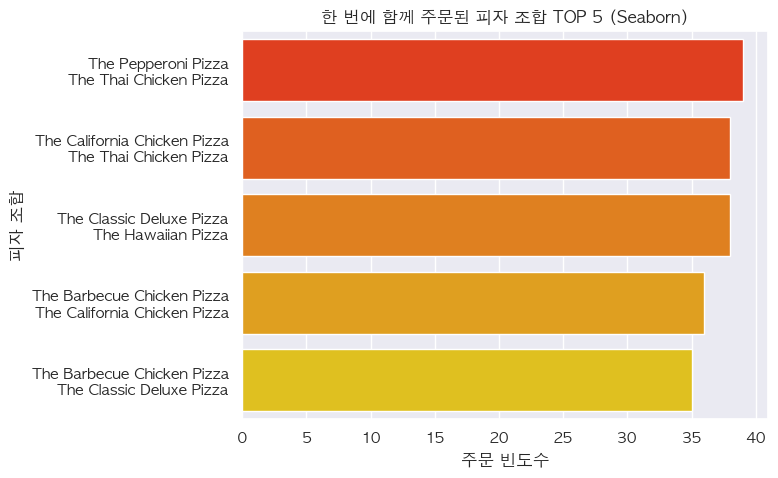

In [44]:
# 튜플을 보기 좋게 문자열로 바꾸기 (예: 피자1\n피자2)
top3_multi_combi_df["피자조합_이름"] = top3_multi_combi_df["피자조합"].apply(lambda x: "\n".join(x))

# seaborn 불러오기
import seaborn as sns

# seaborn을 사용한 가로 막대 그래프 시각화
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top3_multi_combi_df,
    y="피자조합_이름",
    x="빈도수",
    palette="autumn"
)

plt.xlabel("주문 빈도수")
plt.ylabel("피자 조합")
plt.title("한 번에 함께 주문된 피자 조합 TOP 5 (Seaborn)")
plt.tight_layout()
plt.show()

---------------------------------------------------------------------------------

### **🕹️가격대별 고객 취향 세분화 (클러스터링 유사 접근)**

- **목표**: 고객들은 어떤 가격대 + 어떤 종류의 피자를 즐기는가?
- **시각화**: `unit_price`, `category`, `size` 기준 버블 차트
- **활용**: 타깃 고객별 맞춤 프로모션 (ex. 저가+소형 선호 고객층 vs 고가+XL 고객층)

In [46]:
# 가격 구간화 

def 가격구간(가격):
    if 가격 <= 14.99:
        return '저가 (≤ $14.99)'
    elif 15.00 <= 가격 <= 19.99:
        return '중가 ($15.00 ~ $19.99)'
    else:
        return '고가 (≥ $20.00)'

# 단가 기준으로 구간 분류
df['가격 구간'] = df['단가'].apply(가격구간)

# 가격 구간 + 피자 종류별 수량 합계
grouped = df.groupby(['가격 구간', '피자 종류'])['주문 수량'].sum().reset_index()

# 각 가격 구간에서 총 수량 기준으로 비율 계산
grouped['비율'] = grouped.groupby('가격 구간')['주문 수량'].transform(lambda x: round(x / x.sum(), 2))
grouped

# grouped.to_csv('가격대별 피자 종류 분석', index = False, encoding = 'utf-8-sig')

,가격 구간,피자 종류,주문 수량,비율
0,고가 (≥ $20.00),Chicken,4932,0.32
1,고가 (≥ $20.00),Classic,2606,0.17
2,고가 (≥ $20.00),Supreme,5054,0.33
3,고가 (≥ $20.00),Veggie,2678,0.18
4,저가 (≤ $14.99),Chicken,2224,0.14
5,저가 (≤ $14.99),Classic,7958,0.49
6,저가 (≤ $14.99),Supreme,2887,0.18
7,저가 (≤ $14.99),Veggie,3249,0.20
8,중가 ($15.00 ~ $19.99),Chicken,3894,0.22
9,중가 ($15.00 ~ $19.99),Classic,4324,0.24


In [ ]:
# 누적 barplot으로 그려보기

pivot_df = grouped.pivot(index='가격 구간', columns='피자 종류', values='비율')

pivot_df.plot(kind='bar', stacked=True, figsize=(8, 7), colormap='tab20')
plt.title('가격 구간별 피자 종류 선호 비율')
plt.ylabel('비율')
plt.xlabel('가격 구간')
plt.legend(title='피자 종류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# 파이그래프로 그려보기
import matplotlib.pyplot as plt

# 각 가격 구간에 대해 pie chart 반복 생성
구간_리스트 = grouped['가격 구간'].unique()

for 구간 in 구간_리스트:
    # 현재 구간의 데이터 필터링
    temp = grouped[grouped['가격 구간'] == 구간]

    labels = temp['피자 종류']
    sizes = temp['비율']  # 이미 0~1 사이 비율로 되어 있음

    # 차트 생성
    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes, 
        labels=labels, 
        autopct='%1.0f%%', 
        startangle=90, 
        counterclock=False, 
        wedgeprops={'edgecolor': 'white'}
    )
    plt.title(f"{구간} 피자 종류 구성비")
    plt.tight_layout()
    plt.show()


**🔍 인사이트 정리 (보고서/발표용)**

✅ 1. 저가 구간 (≤ $14.99)
Classic 피자 비중 압도적 (~50%)

그 외에는 Supreme, Chicken이 균형 있게 분포

📝 인사이트:

저가 라인은 "전통적인 입맛" 중심. Classic 피자를 중심으로 단일 인기 메뉴 전략이 가능. 원가 절감형 베스트셀러 구성에 적합.

✅ 2. 중가 구간 ($15.00 ~ $19.99)
4가지 종류가 골고루 분포
(Chicken, Classic, Supreme, Veggie 균형 잡힘)

📝 인사이트:

중가 라인은 취향 다양성이 극대화된 구간. 모든 카테고리 피자를 고르게 즐김 → 콤보 메뉴, 혼합 패키지, 커스터마이징 옵션 강화에 적합.

✅ 3. 고가 구간 (≥ $20.00)
Chicken 비율 상승, Classic 감소

Veggie/Supreme도 고르게 유지

📝 인사이트:

고가 피자는 육류 중심의 프리미엄 취향이 뚜렷함. Chicken 피자에 대한 선호가 확연히 드러남. 고단백/고급 토핑 기반 프리미엄 라인 확장 가능.

---------------------------------------------------------------------------------

### **🧄토핑 종류 다양성과 단가 관계 분석 수연님**

- 목표: 토핑이 많을수록 가격이 비쌀까?
- 전처리: Toppings 개수 계산 → Unit Price와 관계 산점도
- 활용: 토핑 추가 가격 정책 검토

In [ ]:
# 토핑 문자열을 , 기준으로 분리한 후 개수 계산
df['토핑 수'] = df['피자 재료 목록'].apply(lambda x: len(x.split(',')))

In [ ]:
# 단가와 토핑수를 산점도로 나타내기

plt.figure(figsize=(8, 5))
plt.scatter(df['토핑 수'], df['단가'], alpha=0.6)
plt.title('토핑 수 vs 단가 관계')
plt.xlabel('토핑 수')
plt.ylabel('단가 ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
corr = df[['토핑 수', '단가']].corr().iloc[0, 1]
print(f"토핑 수와 단가 간 상관계수: {corr:.2f}")

**📌 분석 요약**

X축: 피자당 토핑 수 (2~8개)

Y축: 해당 피자의 단가 ($)

상관계수: 0.35 → 약한~중간 정도의 양의 상관관계

**🔍 데이터 인사이트**

✅ 1. 토핑 수가 많을수록 가격이 오르는 경향
대체로 토핑 수 5~7개일 때 단가가 높은 피자들이 많음

**최고가 피자($35 이상)**도 토핑 6개인 구간에서 등장

✅ 2. 예외 케이스 존재
토핑 수 5~6개지만 단가가 낮은 피자 존재

토핑 수 2~3개임에도 단가가 높은 피자도 일부 존재 → 브랜드 전략 또는 고급 재료 가능성

💬 인사이트 요약 문장 (보고서용)
“토핑 수와 단가는 중간 정도의 양의 상관관계를 보이며, 일반적으로 토핑이 많을수록 가격이 높아지는 경향이 있습니다. 다만 일부 토핑 수가 적어도 가격이 높은 제품이 존재하며, 이는 브랜드 가치나 프리미엄 원재료 사용 등의 요인이 반영된 것으로 해석됩니다.”

---------------------------------------------------------------------------------

### 효준님 Part

In [ ]:
# 중복 제거된 피자 이름과 재료 목록 추출
pizza_ingredients_count = df[['피자 이름', '피자 재료 목록']].drop_duplicates()

# 재료 수 계산
pizza_ingredients_count['재료 수'] = pizza_ingredients_count['피자 재료 목록'].apply(lambda x: len(x.split(',')))

# 재료 수 기준 내림차순 정렬
pizza_ingredients_count_sorted = pizza_ingredients_count.sort_values(by='재료 수', ascending=False)

# 전체 출력
print(pizza_ingredients_count_sorted.to_string(index=False))

In [ ]:
# ✅ 재료 수 계산 (쉼표 기준 split해서 개수 세기)
df['재료 수'] = df['피자 재료 목록'].apply(lambda x: len(x.split(',')))

# ✅ 재료 수별 총 주문 수량 계산
ingredient_group_total = df.groupby('재료 수')['주문 수량'].sum().reset_index()

# ✅ 시각화
plt.figure(figsize=(8, 5))
sns.lineplot(data=ingredient_group_total, x='재료 수', y='주문 수량', marker='o')
plt.title('🧂 토핑 재료 수 vs 총 주문 수량')
plt.xlabel('토핑 재료 수')
plt.ylabel('총 주문 수량')
plt.grid(True)
plt.tight_layout()
plt.show()

🧂 인사이트: 토핑 재료 수와 주문량 관계 분석
📈 관찰 요약
재료 수가 4~6개인 피자가 가장 많은 주문량을 기록함.

재료 수가 2~3개인 단순한 피자는 주문량이 적은 편.

7개 이상 재료를 가진 피자는 개수는 적지만 상대적으로 높은 주문량을 기록하는 경우도 존재함.

🔍 분석 포인트
재료 수	주문 수량 특성	해석
1~3개	낮은 주문 수량	지나치게 단순한 메뉴는 선호도가 낮음
4~6개	주문량 최고 구간	맛의 다양성과 적절한 가격대의 균형 가능성
7개 이상	다소 줄어드는 추세 or 소수 인기	프리미엄 포지션의 가능성, 다만 너무 복잡한 재료는 호불호 존재

💡 마케팅 & 제품 전략 제안
✅ 메인 메뉴군은 4~6개 재료를 사용하는 피자로 구성

→ 예: 베스트셀러, 추천메뉴, 세트 구성용

✅ 단순 피자는 1인 런치용 소형 사이즈로 리포지셔닝

→ 예: 저가 간편식, 배달 전용 메뉴

✅ 7개 이상 재료의 피자는 프리미엄 라인업으로 별도 강조

→ 예: “쉐프 스페셜”, “고급 토핑 한정 메뉴” 등

✨ 활용 방안
신메뉴 개발 시 재료 개수 타겟 범위는 4~6개로 설정

재료 수에 따른 제작 원가, 소비자 인식, 프로모션 전략 연계 가능

향후 재료 조합별 만족도 조사 또는 리뷰 기반 정성 분석도 고려 가능

In [ ]:
# 피자 이름별로 고정 단가와 총 주문 수량 추출
pizza_price_quantity = df.groupby('피자 이름').agg({
    '단가': 'first',         # 고정 단가
    '주문 수량': 'sum'       # 총 주문 수량
}).reset_index()

# 총 주문 수 기준 내림차순 정렬
pizza_price_quantity_sorted = pizza_price_quantity.sort_values(by='주문 수량', ascending=False)

# 표 출력
print(pizza_price_quantity_sorted.to_string(index=False))

In [ ]:
# 단가 구간 분류 함수
def 가격_구간(가격):
    if 가격 <= 14.99:
        return '저가 (≤ $14.99)'
    elif 15.00 <= 가격 <= 19.99:
        return '중가 ($15.00 ~ $19.99)'
    else:
        return '고가 (≥ $20.00)'

# 단가 기준으로 구간 분류 컬럼 추가
df['가격 구간'] = df['단가'].apply(가격_구간)

# 각 가격 구간별 총 주문 수량 계산
price_group_summary = df.groupby('가격 구간')['주문 수량'].sum().reset_index()

# 보기 좋게 가격 구간 정렬
price_group_summary = price_group_summary.sort_values(by='주문 수량', ascending=False)

# 결과 확인
print(price_group_summary.to_string(index=False))


In [ ]:
# 3. 구간별 **총 주문 수량** 집계 (막대차트용으로도 동일하게 사용)
price_group_summary = df.groupby('가격 구간')['주문 수량'].sum().reset_index()

# --------------- 그래프 1: 파이차트 ----------------
plt.figure(figsize=(5, 5))
plt.pie(price_group_summary['주문 수량'], labels=price_group_summary['가격 구간'],
        autopct='%1.1f%%', startangle=90)
plt.title('가격 구간별 총 주문 수량 비중 (파이차트)')
plt.axis('equal')
plt.tight_layout()
plt.show()

# --------------- 그래프 2: 막대차트 ----------------
plt.figure(figsize=(7, 5))
sns.barplot(data=price_group_summary, x='가격 구간', y='주문 수량')
plt.title('가격 구간별 총 주문 수량 (막대차트)')
plt.xlabel('가격 구간')
plt.ylabel('총 주문 수량')
plt.tight_layout()
plt.show()

# --------------- 그래프 3: 산점도 ----------------
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='단가', y='주문 수량', hue='가격 구간', palette='Set2', alpha=0.6)
plt.title('단가 vs 주문 수량 (산점도)')
plt.xlabel('피자 단가 ($)')
plt.ylabel('주문 수량')
plt.legend(title='가격 구간')
plt.grid(True)
plt.tight_layout()
plt.show()


🧠 1. 가격 구간별 총 주문 수량 비중 (파이차트)
📊 그래프 요약:
저가 (≤ $14.99) 피자가 전체 판매량의 가장 큰 비중을 차지

고가 (≥ $20.00)는 상대적으로 소수

🔍 인사이트:
저가 피자가 전체 판매량의 주력 상품입니다.
→ 단품/점심용/1인용 등으로 자주 팔리는 구조일 수 있음

고가 피자 수요도 존재하지만 소수
→ 마진율은 높을 수 있으나 수요는 제한적 → 프리미엄은 한정 판매 전략 적합

🧠 2. 가격 구간별 총 주문 수량 (막대차트)
📊 그래프 요약:
세 구간 중 저가 피자 > 중가 피자 > 고가 피자 순으로 많이 팔림

고가 피자는 판매량이 확실히 떨어짐

🔍 인사이트:
전체 수요 기반 전략에서는 중저가 라인이 핵심

중가 피자도 꽤 견고한 수요가 있음 → 가족 단위/공동 소비

고가 피자는 적은 수요지만 고정 고객층 가능성
→ 브랜드 피자, 특별한 날, 고급 재료 위주 마케팅이 어울림

🧠 3. 단가 vs 주문 수량 (산점도)
📊 그래프 요약:
단가가 낮을수록 전반적으로 주문 수량이 높은 경향

고가 피자(≥$20)는 대부분 수량이 낮음 (희소하게 몇 개만 조금 팔림)

🔍 인사이트:
단가가 높아질수록 수요가 급격히 낮아지는 경향이 뚜렷
→ 가격 민감도가 높은 시장

단가를 약간 낮춰도 주문 수 증가가 기대될 수 있음
→ $20 근처 제품은 가격 전략 조정 필요성 있음

In [ ]:
# 피자 사이즈별 총 주문 수량 계산
size_quantity = df.groupby('피자 사이즈')['주문 수량'].sum().reset_index()

# 주문 수량 기준 내림차순 정렬
size_quantity = size_quantity.sort_values(by='주문 수량', ascending=False)

# 표 출력
print(size_quantity.to_string(index=False))


In [ ]:
# 1. 피자 사이즈별 총 주문 수량 계산 및 정렬
size_quantity = df.groupby('피자 사이즈')['주문 수량'].sum().reset_index()
size_quantity = size_quantity.sort_values(by='주문 수량', ascending=False)

# 2. 파이차트: 사이즈별 비중
plt.figure(figsize=(6, 6))
plt.pie(
    size_quantity['주문 수량'],
    labels=size_quantity['피자 사이즈'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('📐 피자 사이즈별 주문 비중 (파이차트)')
plt.axis('equal')
plt.tight_layout()
plt.show()

# 3. 막대차트: 사이즈별 주문 수량
plt.figure(figsize=(8, 5))
sns.barplot(data=size_quantity, x='피자 사이즈', y='주문 수량', palette='Set3')
plt.title('📐 피자 사이즈별 주문 수량 (막대차트)')
plt.xlabel('피자 사이즈')
plt.ylabel('총 주문 수량')
plt.tight_layout()
plt.show()

가격 구간	총 주문 수량	비중
중가 ($15~$19.99)	17,986	37.0%
저가 (≤ $14.99)	16,318	33.6%
고가 (≥ $20)	15,270	29.4%

인사이트:
가격대가 고르게 분포됨 → 고객층 다양

중가 라인은 매출 안정화, 저가는 고객 유입, 고가는 마진 확보

세 가지 라인을 전략적으로 분화하여 포지셔닝 필요

In [ ]:
# 피자 종류별 주문 수량 집계
category_quantity = df.groupby('피자 종류')['주문 수량'].sum().reset_index()

# 주문 수량 기준 내림차순 정렬
category_quantity = category_quantity.sort_values(by='주문 수량', ascending=False)

# 표 출력
print(category_quantity.to_string(index=False))

In [ ]:
# 1. 피자 종류별 주문 수량 집계
category_quantity = df.groupby('피자 종류')['주문 수량'].sum().reset_index()
category_quantity = category_quantity.sort_values(by='주문 수량', ascending=False)

# 2. 막대차트
plt.figure(figsize=(8, 5))
sns.barplot(data=category_quantity, x='피자 종류', y='주문 수량', palette='Set2')
plt.title('📊 피자 종류별 주문 수량 (막대차트)')
plt.xlabel('피자 종류')
plt.ylabel('총 주문 수량')
plt.tight_layout()
plt.show()

# 3. 파이차트
plt.figure(figsize=(6, 6))
plt.pie(
    category_quantity['주문 수량'],
    labels=category_quantity['피자 종류'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('📊 피자 종류별 주문 비중 (파이차트)')
plt.axis('equal')
plt.tight_layout()
plt.show()

사이즈별 판매 비중
사이즈	총 주문 수량	비중 추정
L	18,956	39%
M	15,635	32%
S	14,403	29%

인사이트:
L 사이즈가 압도적 1위 → 가족, 친구와 나눠먹는 구성 선호

M, S도 비중 큼 → 1~2인 소비층도 충분히 존재

대형 프로모션은 L 사이즈 중심, 소형은 점심/1인 가구 타깃

In [ ]:
## 인기 피자 TOP 10 추출


# 피자 이름별 총 주문 수량 계산
pizza_top10 = df.groupby('피자 이름')['주문 수량'].sum().reset_index()

# 주문 수량 기준 내림차순 정렬 후 상위 10개 추출
pizza_top10 = pizza_top10.sort_values(by='주문 수량', ascending=False).head(10)

# TOP 10 피자 정보 추출 (피자 이름 기준으로 원본과 merge)
pizza_info = df.drop_duplicates(subset='피자 이름')[['피자 이름', '피자 종류', '피자 사이즈', '단가', '피자 재료 목록']]
pizza_top10_full = pd.merge(pizza_top10, pizza_info, on='피자 이름', how='left')

# 재료 수 컬럼 추가
pizza_top10_full['재료 수'] = pizza_top10_full['피자 재료 목록'].apply(lambda x: len(x.split(',')))

# 정리된 표 출력
print(pizza_top10_full.to_string(index=False))

In [ ]:
##단가/재료/사이즈/카테고리별 피자 효율 분석

# 피자 이름별 평균 주문 수량 계산
pizza_summary = df.groupby('피자 이름')['주문 수량'].mean().reset_index()

# 고유 피자 정보 병합 (중복 제거)
pizza_info_full = df.drop_duplicates(subset='피자 이름')[['피자 이름', '단가', '피자 사이즈', '피자 종류', '피자 재료 목록']]

# 재료 수 컬럼 추가
pizza_info_full['재료 수'] = pizza_info_full['피자 재료 목록'].apply(lambda x: len(x.split(',')))

# 병합: 피자별 요약 테이블
pizza_efficiency = pd.merge(pizza_summary, pizza_info_full, on='피자 이름', how='left')

# 주문 수량 기준 정렬
pizza_efficiency = pizza_efficiency.sort_values(by='주문 수량', ascending=False)

# 표 출력
print(pizza_efficiency.to_string(index=False))

In [ ]:
## 어떤 토핑이 제일 많이 들어갔을까

from collections import Counter

# 모든 피자의 재료 목록을 하나의 리스트로 펼치기
all_ingredients = df['피자 재료 목록'].apply(lambda x: [i.strip() for i in x.split(',')])
flat_list = [ingredient for sublist in all_ingredients for ingredient in sublist]

# 재료별 등장 횟수 카운트
ingredient_counts = Counter(flat_list)

# DataFrame으로 정리
ingredient_df = pd.DataFrame(ingredient_counts.items(), columns=['재료명', '등장 횟수'])

# 등장 횟수 기준 내림차순 정렬
ingredient_df = ingredient_df.sort_values(by='등장 횟수', ascending=False).reset_index(drop=True)

# 표 출력
print(ingredient_df.to_string(index=False))


토핑 재료 등장 순위 TOP 10
재료명	등장 횟수	포지션
Garlic	27,422	거의 모든 피자 기본
Tomatoes	26,601	소스/재료 전방위 활용
Red Onions	19,547	중간 토핑
Red Peppers	16,284	상단 토핑
Mozzarella Cheese	10,333	핵심 치즈
Pepperoni	10,300	고기 토핑 대표

인사이트:
마늘, 토마토, 양파는 핵심 베이스 → 공급 안정성과 원가 관리 필요

페퍼로니, 치즈는 고급 피자 핵심 토핑

재료 등장 순서를 바탕으로 공통 베이스 피자 조합 (예: 마늘+토마토+치즈) 개발 가능

 종합 마케팅/제품 전략 제안
전략 영역	제안 내용
제품 개발	- 인기 재료 기반 베이스 조합 최적화
- Veggie 시리즈 라인 확장 (건강식/비건 타깃)
- M사이즈 중심 점심 전용 메뉴 개발
메뉴 포지션	- 중가 Classic & Veggie 중심
- 고가 프리미엄은 한정판/특별 테마로 고정비 방지
마케팅	- "건강한 채식 피자도 맛있다!" 테마
- "한 판이면 충분해" L사이즈 강조
- "우리의 베이스는 다르다" 핵심 재료 강조형 캠페인
공급전략	- Garlic, Tomatoes, Onion은 계약재배 or 대량구매로 원가 절감
- 페퍼로니/치즈는 프리미엄 라인 전용으로 분리 관리

In [ ]:
# 1. 피자 이름별 단가 + 총 주문 수량
#pizza_price_quantity_sorted.to_csv('피자_별_단가_및_총_주문수량.csv', index=False, encoding='utf-8-sig')

# 2. 가격 구간별 총 주문 수량
#price_group_summary.to_csv('가격_구간별_총_주문수량.csv', index=False, encoding='utf-8-sig')

# 3. 토핑 재료 수 vs 총 주문 수량
#ingredient_group_total.to_csv('재료수_별_총_주문수량.csv', index=False, encoding='utf-8-sig')

# 4. 피자 이름별 재료 수
#ingredient_count_sorted.to_csv('피자_별_재료_수.csv', index=False, encoding='utf-8-sig')

# 5. 토핑 종류별 등장 횟수
#topping_count_df.to_csv('토핑_종류별_등장횟수.csv', index=False, encoding='utf-8-sig')


In [ ]:
# 피자 이름별로 토핑 재료 수 계산
ingredient_count = df.groupby('피자 이름')['피자 재료 목록'].first().apply(lambda x: len(x.split(','))).reset_index()
ingredient_count.columns = ['피자 이름', '재료 수']

# 재료 수 기준으로 정렬
ingredient_count_sorted = ingredient_count.sort_values(by='재료 수', ascending=False)


In [ ]:
# 모든 피자의 재료 리스트 합치고, 재료별 등장 횟수 세기
from collections import Counter
topping_series = df['피자 재료 목록'].str.split(',').explode().str.strip()
topping_counts = Counter(topping_series)
topping_count_df = pd.DataFrame(topping_counts.items(), columns=['토핑', '등장 횟수']).sort_values(by='등장 횟수', ascending=False)

---------------------------------------------------------------------------------

### 설연님 Part 
: 컬럼명 달라서 다른 파일로 봐야함

---------------------------------------------------------------------------------

### 현석님 Part

### **☀️주문 날짜(계절별(3,4,5/6,7,8/9,10,11/12,1,2)) 주문을 많이 하는 계절별로 주문량이 많은 메뉴 TOP5를 골라보자. 현석님**
시즌메뉴를 구성해보자.

In [73]:
df.isna().sum()

피자 ID           0
주문 ID           0
피자 이름 ID        0
주문 수량           0
주문 날짜       29033
주문 요일           0
주문 시간           0
단가              0
총액              0
피자 사이즈          0
피자 종류           0
피자 재료 목록        0
피자 이름           0
월               0
분기              0
dtype: int64

In [75]:
df = pd.read_csv('../Pizza Sales Dataset.csv')

df.rename(columns={
    'pizza_id': '피자 ID',
    'order_id': '주문 ID',
    'pizza_name_id': '피자 이름 ID',
    'quantity': '주문 수량',
    'order_date': '주문 날짜',
    'order_day': '주문 요일',
    'order_time': '주문 시간',
    'unit_price': '단가',
    'total_price': '총액',
    'pizza_size': '피자 사이즈',
    'pizza_category': '피자 종류',
    'pizza_ingredients': '피자 재료 목록',
    'pizza_name': '피자 이름'
}, inplace=True)

피자 ID       0
주문 ID       0
피자 이름 ID    0
주문 수량       0
주문 날짜       0
주문 요일       0
주문 시간       0
단가          0
총액          0
피자 사이즈      0
피자 종류       0
피자 재료 목록    0
피자 이름       0
dtype: int64

🚨 dayfirst = True로 하면 오류나서 False로 고침
오류나는 이유 :"1/13/2015"은 미국식 포맷으로 1월 13일이 맞음

그런데 dayfirst=True로 주면, 13일 1월로 해석하려 하다가 "13월은 없다!"고 터진 겁니다.

In [81]:
#년/월/일 순으로 바꾸기 위해 datetime type으로 자료형을 바꾼다.
df['주문 날짜'] = pd.to_datetime(df['주문 날짜'], dayfirst=False, errors='raise')
#데이터 타입이 datetime64[ns]여야함.
print(df['주문 날짜'].dtype)
# 년/월/일 순으로 바꾼다.
df['주문 날짜'] = df['주문 날짜'].dt.strftime('%Y/%m/%d')
# 월 정보를 추출하는 칼럼을 생성한다.
df['월'] = df['주문 날짜'].str.slice(5, 7).astype(int)

datetime64[ns]


In [78]:
# 월 정보를 분기로 나눈다.
def 분기_3개월(month):
    if month in [3, 4, 5]:
        return '봄(3~5월)'
    elif month in [6, 7, 8]:
        return '여름(6~8월)'
    elif month in [9, 10, 11]:
        return '가을(9~11월)'
    else:  # 12, 1, 2
        return '겨울(12~2월)'

df['분기'] = df['월'].apply(분기_3개월)

In [79]:
# 분기별 피자이름의 주문 수량 합계
분기별_피자이름_합계 = (
    df.groupby(['분기', '피자 이름'])['주문 수량']
      .sum()
      .reset_index(name='총주문수량')
      .sort_values(['분기', '총주문수량'], ascending=[True, False]))

In [82]:
#TOP5만 구해본다.
top5_분기별_피자이름 = (
    분기별_피자이름_합계
    .groupby('분기')
    .head(5)
    .reset_index(drop=True)
)

print(top5_분기별_피자이름)

           분기                         피자 이름  총주문수량
0   가을(9~11월)      The Classic Deluxe Pizza    623
1   가을(9~11월)            The Hawaiian Pizza    611
2   가을(9~11월)        The Thai Chicken Pizza    602
3   가을(9~11월)           The Pepperoni Pizza    593
4   가을(9~11월)    The Barbecue Chicken Pizza    581
5   겨울(12~2월)           The Pepperoni Pizza    627
6   겨울(12~2월)  The California Chicken Pizza    613
7   겨울(12~2월)            The Hawaiian Pizza    592
8   겨울(12~2월)    The Barbecue Chicken Pizza    580
9   겨울(12~2월)        The Thai Chicken Pizza    570
10    봄(3~5월)    The Barbecue Chicken Pizza    671
11    봄(3~5월)      The Classic Deluxe Pizza    638
12    봄(3~5월)            The Hawaiian Pizza    634
13    봄(3~5월)        The Thai Chicken Pizza    608
14    봄(3~5월)           The Pepperoni Pizza    599
15   여름(6~8월)  The California Chicken Pizza    640
16   여름(6~8월)      The Classic Deluxe Pizza    632
17   여름(6~8월)    The Barbecue Chicken Pizza    600
18   여름(6~8월)           The Pep

In [83]:
#TOP20만 구해본다.
top20_분기별_피자이름 = (
    분기별_피자이름_합계
    .groupby('분기')
    .head(20)
    .reset_index(drop=True)
)

print(top20_분기별_피자이름)

           분기                                       피자 이름  총주문수량
0   가을(9~11월)                    The Classic Deluxe Pizza    623
1   가을(9~11월)                          The Hawaiian Pizza    611
2   가을(9~11월)                      The Thai Chicken Pizza    602
3   가을(9~11월)                         The Pepperoni Pizza    593
4   가을(9~11월)                  The Barbecue Chicken Pizza    581
..        ...                                         ...    ...
75   여름(6~8월)  The Pepperoni, Mushroom, and Peppers Pizza    384
76   여름(6~8월)                  The Spinach and Feta Pizza    384
77   여름(6~8월)                 The Italian Capocollo Pizza    377
78   여름(6~8월)                       The Five Cheese Pizza    376
79   여름(6~8월)            The Prosciutto and Arugula Pizza    364

[80 rows x 3 columns]


## ⬇️피자 타입이라는 컬럼이 어디있죠 ??

In [86]:
a1 = df['피자타입'].nunique()
a2 = df['피자 이름'].nunique()
a3 = df['피자 종류'].nunique()
print(a1,a2,a3)

KeyError: '피자타입'

In [87]:
# top20_분기별_피자이름.to_csv('분기별피자자_Top20.csv', index=False, encoding='utf-8-sig')

### **🥣점심 주문이 많나 저녁 주문이 많나? 현석님**
(오픈시간 중 주문량이 적은 시간에 할인 이벤트로 주문 유도)

마찬가지로 통계적으로 주문이 적은 요일에 할인이벤트로 주문 유도

In [88]:
print(df['주문 시간'].dtype)

object


In [89]:
# 1. 시간 형식으로 변환 (시간만 있는 경우 'datetime.time' 형태로 변환 가능)
df['주문 시간 변환'] = pd.to_datetime(df['주문 시간'], format='%H:%M:%S').dt.time

# 2. 변환한 시간 기준으로 정렬
df_sorted = df.sort_values(by='주문 시간 변환')

# 3. 정렬 결과 확인
print(df_sorted)

       피자 ID  주문 ID        피자 이름 ID  주문 수량       주문 날짜     주문 요일     주문 시간  \
43612  43613  19176      hawaiian_l      1  2015/11/24   Tuesday   9:52:21   
43613  43614  19176  peppr_salami_l      1  2015/11/24   Tuesday   9:52:21   
43614  43615  19176    the_greek_xl      1  2015/11/24   Tuesday   9:52:21   
43615  43616  19176    veggie_veg_l      1  2015/11/24   Tuesday   9:52:21   
34189  34190  15092     pepperoni_m      1  2015/09/10  Thursday  10:25:19   
...      ...    ...             ...    ...         ...       ...       ...   
7096    7097   3133   soppressata_l      1  2015/02/21  Saturday  23:05:24   
7095    7096   3133    napolitana_l      1  2015/02/21  Saturday  23:05:24   
7094    7095   3133  mediterraneo_l      1  2015/02/21  Saturday  23:05:24   
28219  28220  12433  spinach_supr_m      1  2015/07/26    Sunday  23:05:52   
28220  28221  12433    veggie_veg_m      1  2015/07/26    Sunday  23:05:52   

          단가     총액 피자 사이즈    피자 종류  \
43612  16.50  16.50     

**오전 주문도 존재하므로 시간대를 아침 : 9시부터 11시이전,점심 : 11시부터 3시이전,브레이크타임 : 3시부터 5시이전,저녁 : 5시부터 9시이전,야간 : 9시부터 12시이전으로 나누어본다**

In [90]:
#datetime type으로 변환
df['주문 시간 변환'] = pd.to_datetime(df['주문 시간'], format='%H:%M:%S', errors='coerce').dt.hour

In [94]:
#시간대 칼럼을 생성성
def 시간대(hour):
    if 9 <= hour < 11:
        return '아침'
    elif 11 <= hour < 15:
        return '점심'
    elif 15 <= hour < 17:
        return '브레이크타임'
    elif 17 <= hour < 21:
        return '저녁'
    elif 21 <= hour < 24:
        return '야간'
    else:
        return '기타'  # 예: 0~8시 또는 결측치 처리

df['시간대'] = df['주문 시간 변환'].apply(시간대)

In [95]:
df.groupby('시간대').size().reset_index(name='주문수')

,시간대,주문수
0,브레이크타임,7355
1,아침,21
2,야간,3966
3,저녁,18339
4,점심,18939


**아침(9-11)에는 주문 수가 거의 없고 점심(11-3),저녁(5-9) 주문량이 최대 브레이크타임(3-5) 주문량이 점심, 저녁의 약 40퍼센트인데 이는 시간 간격상 때문일 수도 있으므로 다시 1시간 간격으로 조사한다.**

In [100]:
#9시부터 23시까지 필터링 (23시~24시 구간을 위해 23까지 포함)
df_valid = df[df['주문 시간 변환'].between(9, 23)].copy()

#시작시간 라벨 생성
df_valid['시간대'] = df_valid['주문 시간 변환'].astype(str) + '시~' + (df_valid['주문 시간 변환'] + 1).astype(str) + '시'

#시간대별 개수 세기
시간대별_개수 = (
    df_valid['시간대']
    .value_counts()
    .reset_index()
    .rename(columns={'index': '시간대', '시간대': '개수'})
)

#시간대 문자열을 기준으로 정렬하기 위해 시작시간 숫자 추출
시간대별_개수['시작시간'] = 시간대별_개수['시간대'].str.split('시').str[0].astype(int)

#시작시간 기준 오름차순 정렬 후 필요 없는 컬럼 삭제
시간대별_개수 = 시간대별_개수.sort_values('시작시간').drop(columns='시작시간').reset_index(drop=True)

#출력
print(시간대별_개수)

KeyError: '시간대'

In [98]:
# 분위수 계산
q25 = 시간대별_개수['개수'].quantile(0.25)
q50 = 시간대별_개수['개수'].quantile(0.50)
q75 = 시간대별_개수['개수'].quantile(0.75)

plt.figure(figsize=(10, 6))

# 시간대별 개수를 점으로 시각화
sns.scatterplot(x='시간대', y='개수', data=시간대별_개수, s=100, color='red', label='시간대별 개수')

# 분위수 기준선 추가
plt.axhline(q25, color='blue', linestyle='--', label='25% 분위수')
plt.axhline(q50, color='green', linestyle='--', label='50% 분위수 (중앙값)')
plt.axhline(q75, color='purple', linestyle='--', label='75% 분위수')

# 시각적 요소 설정
plt.title('시간대별 개수 + 분위수 기준선')
plt.xlabel('시간대')
plt.ylabel('개수')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

11-12 : 점심시간 전 1시간으로 점심시간 진입 구간 >> 주문량 서서히 증가
15-16(오후3시-4시) : 점심시간 끝난 후 1시간으로 >> 주문량 서서히 감소 - 할인행사 해볼법하지만 주문량은 중앙값에 가까움.
21-23(오후9시~11시) : 주문량이 감소하였고 중앙값에 한참 모자람. 야식 시간이므로 이 때 주문량 증가를 위해 할인이벤트를 해볼만함.

In [104]:
# # 시간대별_개수 DataFrame을 CSV 파일로 저장
# 시간대별_개수.to_csv('시간대별_주문수.csv', index=False, encoding='utf-8-sig')

### **🔄 피자 크기 조합 분석 – 어떤 사이즈 조합이 자주 같이 팔릴까? 현석님**

목표: 한 주문 안에서 어떤 사이즈 조합이 자주 등장하는가?
전처리: Order ID별 Size 조합 분석
시각화: 크기 조합별 빈도수 히트맵
활용: 세트 구성 최적화 (예: M + L 구성 세트 메뉴)


주문 조합을 보기 앞서서 몇개를 한번에 주문하는 지 빈도를 파악한다.

In [105]:

# 주문 ID별 피자 사이즈 리스트(정렬 포함)
피자사이즈_조합 = df.groupby('주문 ID')['피자 사이즈'].apply(list).reset_index()

# 조합 내 총 피자 개수 (중복 포함)
피자사이즈_조합['조합개수'] = 피자사이즈_조합['피자 사이즈'].apply(len)

# 조합 문자열 생성 (보기 쉽게)
피자사이즈_조합['조합문자열'] = 피자사이즈_조합['피자 사이즈'].apply(lambda x: ','.join(sorted(x)))

# 조합개수별 빈도수 계산
빈도_조합개수 = 피자사이즈_조합.groupby('조합개수').size().reset_index(name='빈도수')

print(빈도_조합개수)

    조합개수   빈도수
0      1  8201
1      2  6196
2      3  3325
3      4  2888
4      5   144
5      6    75
6      7    75
7      8    83
8      9    65
9     10    59
10    11    69
11    12    71
12    13    52
13    14    38
14    15     7
15    21     2


1개 주문이 제일 많고 그다음 2,3,4개가 뒤를 따른다.

우선 전체 조합에서 TOP10을 가져온다.

In [106]:
# 1. 주문 ID별 피자 사이즈 리스트를 정렬하여 문자열로 결합 (순서 무시)
피자사이즈_조합 = df.groupby('주문 ID')['피자 사이즈'].apply(lambda x: ','.join(sorted(x))).reset_index(name='사이즈조합')

# 2. 조합별 빈도수 세기
조합_빈도 = (
    피자사이즈_조합['사이즈조합']
    .value_counts()
    .reset_index()
    .rename(columns={'index': '사이즈조합', '사이즈조합': '빈도수'})
    .head(10)
)

# 3. 결과 출력
print(조합_빈도)

     빈도수  count
0      L   3102
1      M   2604
2      S   2376
3    L,M   1520
4    L,S   1391
5    M,S   1166
6    L,L    900
7  L,M,S    716
8    M,M    587
9    S,S    493


2개 조합 시 TOP5를 알 수 있는게 3개 조합은 TOP5를 알기 어렵다. 한번 더 구해본다.

In [108]:
# 주문 ID별 사이즈 조합 리스트 (정렬하여 순서 무시)
피자사이즈_조합 = df.groupby('주문 ID')['피자 사이즈'].apply(lambda x: sorted(x)).reset_index()

# 조합 개수 컬럼 추가
피자사이즈_조합['조합개수'] = 피자사이즈_조합['피자 사이즈'].apply(len)

# 조합 문자열 생성
피자사이즈_조합['조합문자열'] = 피자사이즈_조합['피자 사이즈'].apply(lambda x: ','.join(x))

# 조합별 빈도 계산
조합별_빈도 = (
    피자사이즈_조합.groupby(['조합개수', '조합문자열'])
    .size()
    .reset_index(name='빈도수')
)

# 2개 조합 Top10
top2 = 조합별_빈도[조합별_빈도['조합개수'] == 2].sort_values('빈도수', ascending=False).head(10)

# 3개 조합 Top10
top3 = 조합별_빈도[조합별_빈도['조합개수'] == 3].sort_values('빈도수', ascending=False).head(10)

print("=== 사이즈 조합 개수 2개 Top10 ===")
print(top2[['조합문자열', '빈도수']])

print("\n=== 사이즈 조합 개수 3개 Top10 ===")
print(top3[['조합문자열', '빈도수']])

=== 사이즈 조합 개수 2개 Top10 ===
    조합문자열   빈도수
6     L,M  1520
7     L,S  1391
11    M,S  1166
5     L,L   900
10    M,M   587
14    S,S   493
15   S,XL    46
8    L,XL    44
12   M,XL    40
9   L,XXL     4

=== 사이즈 조합 개수 3개 Top10 ===
    조합문자열  빈도수
22  L,M,S  716
18  L,L,M  461
19  L,L,S  414
21  L,M,M  401
25  L,S,S  369
28  M,M,S  266
30  M,S,S  255
17  L,L,L  156
27  M,M,M  103
33  S,S,S   86


In [ ]:
# 사이즈 조합 개수 2개 Top10 저장
#top2.to_csv('조합_2개_Top10.csv', index=False, encoding='utf-8-sig')

# 사이즈 조합 개수 3개 Top10 저장
#top3.to_csv('조합_3개_Top10.csv', index=False, encoding='utf-8-sig')

#빈도_조합개수.to_csv('조합개수별_빈도_Top10.csv', index=False, encoding='utf-8-sig')
 

---------------------------------------------------------------------------------

### 혜원님 Part

### **⏰ 시간대별 주문량 분석 (피크타임 파악)**
목표: 언제 사람들이 피자를 가장 많이 먹는가?
시각화: order_time (= 주문 시간 ) 기준 막대 그래프
활용: 매장 인력 운영, 프로모션 타이밍 설계

In [110]:
df = pd.read_csv('../Pizza Sales Dataset.csv')
df.rename(columns={
    'pizza_id': '피자 ID',
    'order_id': '주문 ID',
    'pizza_name_id': '피자 이름 ID',
    'quantity': '주문 수량',
    'order_date': '주문 날짜',
    'order_day': '주문 요일',
    'order_time': '주문 시간',
    'unit_price': '단가',
    'total_price': '총액',
    'pizza_size': '피자 사이즈',
    'pizza_category': '피자 종류',
    'pizza_ingredients': '피자 재료 목록',
    'pizza_name': '피자 이름'
}, inplace=True)

In [111]:
# 날짜/시간 데이터 정리. > 주문 날짜, 주문 시간 datetime 타입으로 변환
# 날짜 + 시간 합쳐서 datetime 열 만들기
df['주문일시'] = pd.to_datetime(df['주문 날짜'] + ' ' + df['주문 시간'])

# 요일도 숫자로 변경
# 영어 요일 → 한글 매핑
요일_매핑 = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}

df['주문 요일'] = df['주문 요일'].map(요일_매핑)

# 순서 설정
요일_순서 = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
df['주문 요일'] = pd.Categorical(df['주문 요일'], categories=요일_순서, ordered=True)

df['요일_번호'] = df['주문일시'].dt.dayofweek  # 월=0 ~ 일=6
df['시간대'] = df['주문일시'].dt.hour

In [113]:
# '시간대' 컬럼을 기준 / 주문 수
시간대별_주문량 = df['시간대'].value_counts().sort_index()
print(시간대별_주문량)

# '시간대' 칼럼 기준 주문 수 / 데이터프레임으로 변환
시간대별_주문량_df = 시간대별_주문량.reset_index()
시간대별_주문량_df.columns = ['시간대', '주문 수']  # 컬럼 이름 변경 (보기 좋게)

# 데이터프레임 출력
print("\n시간대별 주문 수 데이터프레임:")
print(시간대별_주문량_df)

# CSV 파일로 저장
# 시간대별_주문량_df.to_csv('시간대별_주문량.csv', index=False, encoding='utf-8-sig')

시간대
9        4
10      17
11    2672
12    6543
13    6203
14    3521
15    3170
16    4185
17    5143
18    5359
19    4350
20    3487
21    2528
22    1370
23      68
Name: count, dtype: int64

시간대별 주문 수 데이터프레임:
    시간대  주문 수
0     9     4
1    10    17
2    11  2672
3    12  6543
4    13  6203
5    14  3521
6    15  3170
7    16  4185
8    17  5143
9    18  5359
10   19  4350
11   20  3487
12   21  2528
13   22  1370
14   23    68


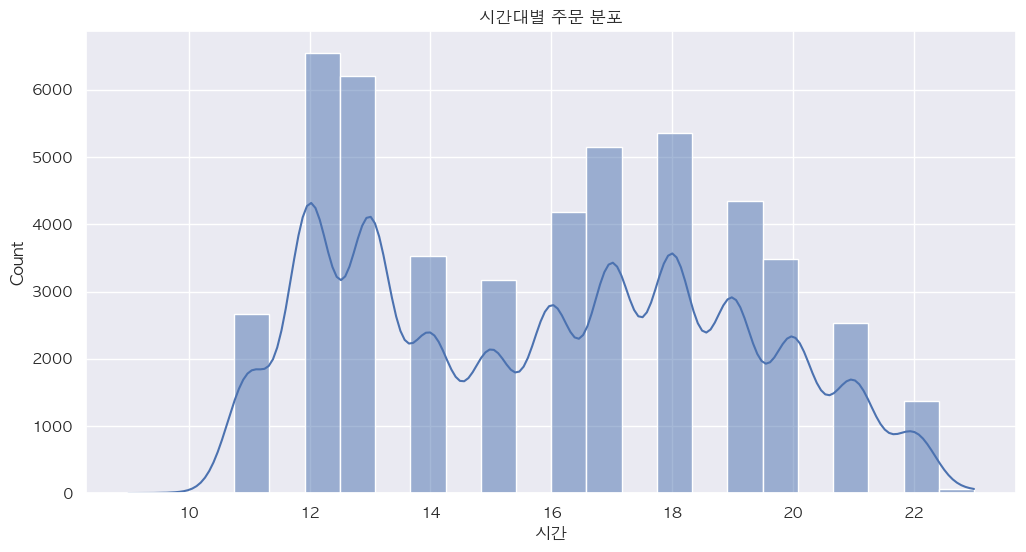

In [114]:

import seaborn as sns
import matplotlib.pyplot as plt

# 시간대별 주문량
sns.histplot(df['시간대'], bins=24, kde=True) # 막대그래프 : 실제 수치, 정확한 주문량 파악 / 선그래프 : 전체 흐름 파악. 트렌드 인식에 유리.
plt.title('시간대별 주문 분포')
plt.xlabel('시간')
plt.show()

## ✅ 시간대별 피자 주문 인사이트

---

### 📊 분석 개요

- **분석 대상**: 피자 주문 데이터  
- **기준**: 주문 일시에서 추출한 **시간대(hour 단위)** 기준으로 주문 수량 집계  
- **시각화**: 히스토그램 + KDE(커널 밀도 추정)로 **주문 집중 시간대 시각화**

---

### ⏰ 주요 인사이트

- 주문량은 **오전보다는 오후~저녁 시간**에 집중됨
  - **정오(12시)** 와 **오후 1시(13시)**: 점심 시간대에 **첫 번째 피크**
  - **오후 5시~7시(17 ~ 19시)**: 퇴근 이후 및 저녁 시간대에 **두 번째 피크**
  - → 두 구간 모두 **식사 시간**과 일치 → 피자 주문이 **식사 대용**으로 집중됨

- **오전 시간대(10시 이전)** 와 **늦은 밤(22시 이후)** 에는 주문 거의 없음  
  → 운영 시간이 제한되었거나, 소비자 니즈가 낮은 시간대

- **가장 주문이 많은 시간**: **정오(12시)**  
  → 마케팅/프로모션 타이밍으로 활용 가능  
  → **배달 인력, 오븐 등 리소스 확보 필요**

- 점심 시간과 저녁 시간 사이인 **14~16시**는 주문량이 감소  
  → **브레이크 타임**으로 해석 가능  
  → **할인/세트 구성 등 수요 창출 전략** 시도할 수 있는 시간대

---

### 💡 활용 제안

- **정오~오후 1시**, **오후 5시~7시** 중심으로 **프로모션 집중**
- **리소스 배치 최적화** (배달 인력, 재료 준비 등) → 피크 시간 대응
- **오후 2시~4시** 사이를 활용한  
  → **간식형 메뉴 출시** or **할인 메뉴 전략** 도입 고려

### 📅 **요일별 주문량 분석 (주말 특수 여부)**

- **목표**: 피자 수요는 주중 vs 주말 어떻게 다른가?
- **시각화**: `order_day` (= `주문 요일`) 기준 막대 그래프
- **활용**: 주말 집중 마케팅 or 할인 전략 근거


요일별 주문 수:
  주문 수  count
0  월요일   6369
1  화요일   6753
2  수요일   6797
3  목요일   7323
4  금요일   8106
5  토요일   7355
6  일요일   5917


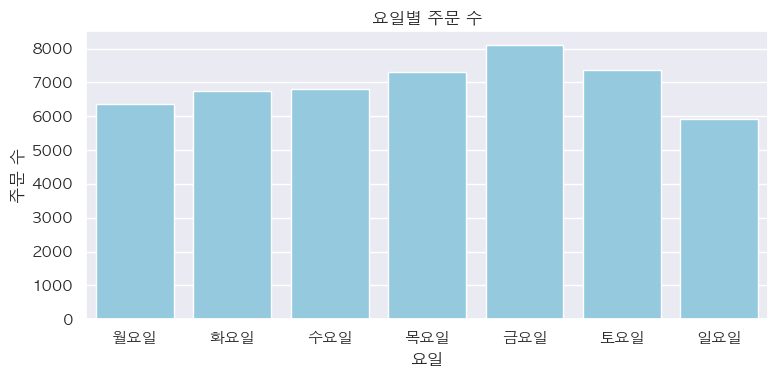


주중/주말 총 주문 수:
  주문 수  count
0   주중  35348
1   주말  13272

주중/주말 하루 평균 주문 수:
   구분  하루 평균 주문 수
0  주중      7069.6
1  주말      6636.0


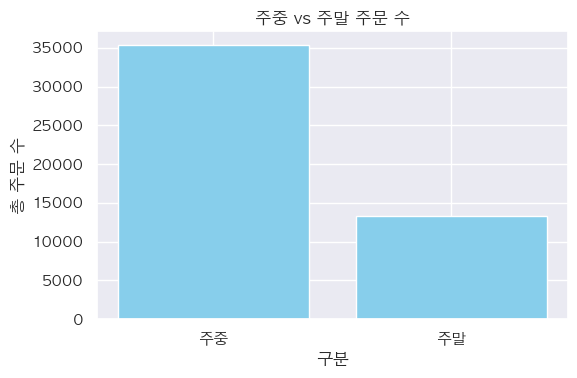

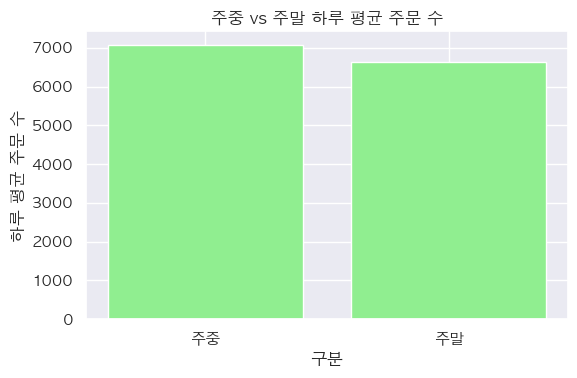


요일 그룹별 총 주문 수:
  주문 수  count
0  월~목  27242
1  금~일  21378

요일 그룹별 하루 평균 주문 수:
  요일 그룹  하루 평균 주문 수
0   월~목      6810.5
1   금~일      7126.0


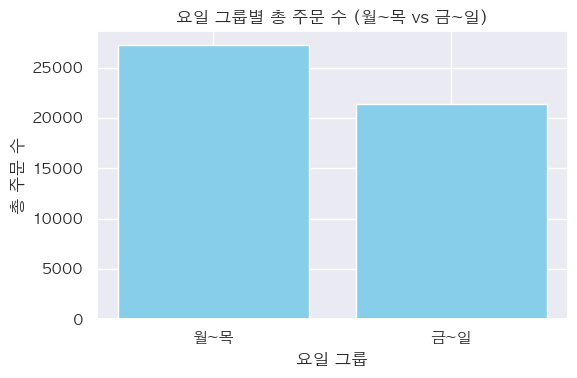

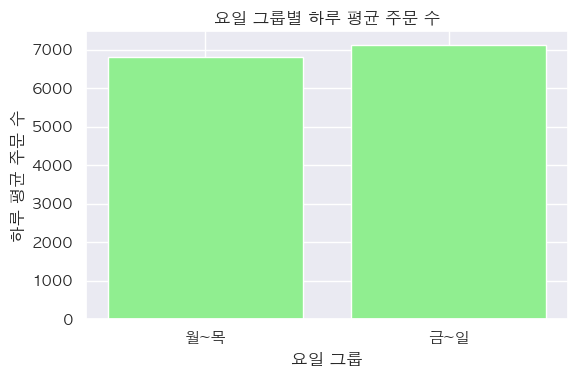

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 태블로에서 사용하기 용이하게 하나로 묶었습니다. 

# 요일 순서 정의 (공통 사용)
요일_순서 = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

# 1. 요일별 주문 수 분석
# 요일별 주문 수 집계 (순서 보장)
요일별_주문량 = df['주문 요일'].value_counts().reindex(요일_순서)

# 요일별 주문 수 - DataFrame 형태로 출력
print("\n요일별 주문 수:")
요일별_df = 요일별_주문량.reset_index().rename(columns={'index': '요일', '주문 요일': '주문 수'})
print(요일별_df)

# 요일별 주문 수 - 시각화
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='주문 요일', order=요일_순서, color='skyblue')
plt.title('요일별 주문 수')
plt.xlabel('요일')
plt.ylabel('주문 수')
plt.tight_layout()
plt.show()

# 2. 주중 vs 주말 분석
# 주중/주말 구분 함수
def 구분_주중_주말(요일):
    return '주말' if 요일 in ['토요일', '일요일'] else '주중'

# 새로운 컬럼 생성
df['주중/주말'] = df['주문 요일'].apply(구분_주중_주말)

# 주중/주말 총 주문 수 집계
주중주말_주문수 = df['주중/주말'].value_counts().reindex(['주중', '주말'])

# 주중/주말 총 주문 수 - DataFrame 형태로 출력
print("\n주중/주말 총 주문 수:")
주중주말_df = 주중주말_주문수.reset_index().rename(columns={'index': '구분', '주중/주말': '주문 수'})
print(주중주말_df)

# 하루 평균 계산
주중_일평균 = 주중주말_주문수['주중'] / 5  # 월~금
주말_일평균 = 주중주말_주문수['주말'] / 2  # 토~일

# 하루 평균 - DataFrame 형태로 출력
print("\n주중/주말 하루 평균 주문 수:")
주중주말_평균_df = pd.DataFrame({
    '구분': ['주중', '주말'],
    '하루 평균 주문 수': [주중_일평균, 주말_일평균]
})
print(주중주말_평균_df)

# 주중/주말 총 주문 수 - 시각화
plt.figure(figsize=(6, 4))
plt.bar(['주중', '주말'], 주중주말_주문수.values, color='skyblue')
plt.title('주중 vs 주말 주문 수')
plt.xlabel('구분')
plt.ylabel('총 주문 수')
plt.tight_layout()
plt.show()

# 하루 평균 주문 수 - 시각화
plt.figure(figsize=(6, 4))
plt.bar(['주중', '주말'], [주중_일평균, 주말_일평균], color='lightgreen')
plt.title('주중 vs 주말 하루 평균 주문 수')
plt.xlabel('구분')
plt.ylabel('하루 평균 주문 수')
plt.tight_layout()
plt.show()

# 3. 요일 그룹 분석 (월~목 vs 금~일)
# 요일 그룹 구분 함수
def 그룹_구분(요일):
    return '월~목' if 요일 in ['월요일', '화요일', '수요일', '목요일'] else '금~일'

# 요일 그룹 컬럼 생성
df['요일 그룹'] = df['주문 요일'].apply(그룹_구분)

# 그룹별 총 주문 수 계산
요일그룹_총주문 = df['요일 그룹'].value_counts().reindex(['월~목', '금~일'])

# 그룹별 총 주문 수 - DataFrame 출력
print("\n요일 그룹별 총 주문 수:")
요일그룹_총_df = 요일그룹_총주문.reset_index().rename(columns={'index': '요일 그룹', '요일 그룹': '주문 수'})
print(요일그룹_총_df)

# 하루 평균 계산 (월~목 = 4일, 금~일 = 3일)
요일그룹_평균주문 = pd.Series({
    '월~목': 요일그룹_총주문['월~목'] / 4,
    '금~일': 요일그룹_총주문['금~일'] / 3
})

# 그룹별 하루 평균 주문 수 - DataFrame 출력
print("\n요일 그룹별 하루 평균 주문 수:")
요일그룹_평균_df = 요일그룹_평균주문.reset_index().rename(columns={'index': '요일 그룹', 0: '하루 평균 주문 수'})
print(요일그룹_평균_df)

# 요일 그룹 총 주문 수 - 시각화
plt.figure(figsize=(6, 4))
plt.bar(요일그룹_총주문.index, 요일그룹_총주문.values, color='skyblue')
plt.title('요일 그룹별 총 주문 수 (월~목 vs 금~일)')
plt.xlabel('요일 그룹')
plt.ylabel('총 주문 수')
plt.tight_layout()
plt.show()

# 요일 그룹 하루 평균 주문 수 - 시각화
plt.figure(figsize=(6, 4))
plt.bar(요일그룹_평균주문.index, 요일그룹_평균주문.values, color='lightgreen')
plt.title('요일 그룹별 하루 평균 주문 수')
plt.xlabel('요일 그룹')
plt.ylabel('하루 평균 주문 수')
plt.tight_layout()
plt.show()

# 4. CSV 저장
# df.to_csv('피자_주문_분석_데이터.csv', index=False, encoding='utf-8-sig')

## ✅ 요일별 & 주중/주말 피자 주문 인사이트

---

### 📊 분석 개요

- **분석 대상**: 해외 피자 주문 데이터셋 (미국 기반 추정)
- **분석 항목**:
  - `주문 요일` 기준 **요일별 주문량 집계**
  - `주중/주말`, `요일 그룹(월~목 / 금~일)` 기준 **총 주문량** 및 **하루 평균 비교**

---

### 📅 요일별 인사이트

- **주중(월~금)** 주문량이 **전체의 약 73%** 차지
- 특히 **수요일~금요일** 사이 주문량이 가장 많음  
  → 직장인 중심의 **점심 회식**, **업무 피로 해소형 외식** 수요로 해석 가능

- **주말(토~일)** 에도 주문량이 적지 않음  
  → **가정 중심 소비**, **주말 여가/파티 수요**를 반영하는 흐름

- **요일별 특징 요약**:
  - **수~금**: 최고 피크
  - **월~화**: 다소 낮은 수요
  - **토~일**: 꾸준한 주말 수요 유지

---

### 📆 주중/주말 비교 인사이트

| 구분 | 총 주문 수 | 하루 평균 주문 수 |
|------|------------|-------------------|
| 주중 | 약 35,000건 | 약 7,000건         |
| 주말 | 약 13,000건 | 약 6,600건         |

- **총 주문 수 기준**: 주중이 뚜렷하게 우세
- **하루 평균 기준**: 주중·주말 **큰 차이 없음**  
  → 주말도 **충분히 중요한 판매 시간대**라는 점....

---

### 🗓️ 요일 그룹 분석 (월 ~ 목 / 금 ~ 일)

- **월~목** (업무일 중심) → **일평균 약 6,570건**
- **금~일** (주말/전야 중심) → **일평균 약 6,750건**

📌 **해석 포인트**:
- **금요일 이후부터의 '주말 모드' 진입**이 수요에 큰 영향을 미침
- 따라서 **금~일을 하나의 세트로 보고 마케팅 전략 설정** 필요

---

### 🌍 미국 문화적 배경 참고

> 미국에서는 피자를 **한 끼 식사 대체재**로 소비하는 문화가 강함  
> 특히 사무실·학교 중심의 **단체 점심 주문**이 흔함  
> → 이로 인해 **주중 수요가 높고, 점심 시간 집중도가 강함**

- **주중 집중 = 문화적 영향 + 직장 기반 소비 패턴**
- **주말 수요 존재 = 가족/여가 중심의 외식 대체**

---

### 💡 한국 시장 적용 제안

| 요일 구간 | 전략 방향 |
|-----------|-----------|
| 월~목 (업무일) | ✅ 오피스 밀집 지역 중심 타겟팅  
→ 점심 특가, 1인 세트, 빠른 배달 |
| 금~일 (주말모드) | ✅ 가족·개인 타깃 마케팅  
→ 홈파티 세트, 키즈 메뉴, 여가 연계 |

- **운영 인력 배치**: 수요일~일요일 중심으로 집중 배치
- **광고 및 메뉴 전략**: 요일별 수요 흐름에 맞춘 타겟 마케팅 강화
- **특히 금요일 이후 수요 확대**를 감안한 **3일 단위 프로모션 전략** 고려

---

> ✅ 해외 데이터 특성과 함께,  
> **한국형 소비 패턴(회식, 야근, 가족 외식 등)에 맞춘 적용이 핵심**

### 🍕 **피자 종류별 판매량 TOP 10**

- **목표**: 어떤 피자가 잘 팔리는가?
- **시각화**: `pizza_name` (=`피자 이름`) 기준 상위 판매량 그래프
- **활용**: 메뉴 구성 / 베스트 메뉴 강조 포스터 설계

In [117]:
# 피자 이름별로 주문 수량 합산
피자_수량_전체 = df.groupby('피자 이름')['주문 수량'].sum().sort_values(ascending=False)

# 전체 결과 확인
print(피자_수량_전체)

피자 이름
The Classic Deluxe Pizza                      2453
The Barbecue Chicken Pizza                    2432
The Hawaiian Pizza                            2422
The Pepperoni Pizza                           2418
The Thai Chicken Pizza                        2371
The California Chicken Pizza                  2370
The Sicilian Pizza                            1938
The Spicy Italian Pizza                       1924
The Southwest Chicken Pizza                   1917
The Big Meat Pizza                            1914
The Four Cheese Pizza                         1902
The Italian Supreme Pizza                     1884
The Vegetables + Vegetables Pizza             1526
The Mexicana Pizza                            1484
The Napolitana Pizza                          1464
The Prosciutto and Arugula Pizza              1457
The Spinach and Feta Pizza                    1446
The Pepper Salami Pizza                       1446
The Italian Capocollo Pizza                   1438
The Greek Pizza          

피자 이름
The Classic Deluxe Pizza        2453
The Barbecue Chicken Pizza      2432
The Hawaiian Pizza              2422
The Pepperoni Pizza             2418
The Thai Chicken Pizza          2371
The California Chicken Pizza    2370
The Sicilian Pizza              1938
The Spicy Italian Pizza         1924
The Southwest Chicken Pizza     1917
The Big Meat Pizza              1914
Name: 주문 수량, dtype: int64


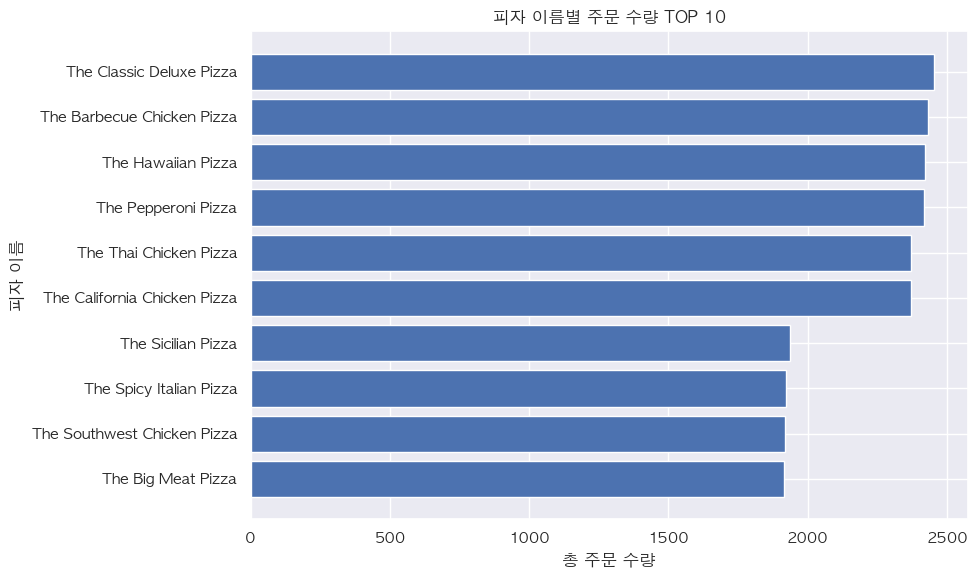

In [118]:
# 상위 10개만 추출
피자_상위10 = 피자_수량_전체.head(10)
print(피자_상위10)

# 피자 이름별 주문 수량 TOP10 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(피자_상위10.index[::-1], 피자_상위10.values[::-1])  # 큰 값이 위로 오도록 순서 반전
plt.title('피자 이름별 주문 수량 TOP 10')
plt.xlabel('총 주문 수량')
plt.ylabel('피자 이름')
plt.tight_layout()
plt.show()

## ✅ 피자 이름별 주문 수량 TOP 10 인사이트

---

### 📊 분석 개요

- **분석 기준**: `'피자 이름'`을 기준으로 `'주문 수량'` 합산  
- **정렬 방식**: 총 주문 수량 기준 내림차순 정렬
- **대상**: 상위 10개 피자 메뉴

---

### 🥇 판매량 상위 TOP 10 피자

1. **The Classic Deluxe Pizza**
2. **The Barbecue Chicken Pizza**
3. **The Hawaiian Pizza**
4. **The Pepperoni Pizza**
5. **The Thai Chicken Pizza**
6. **The California Chicken Pizza**
7. **The Sicilian Pizza**
8. **The Spicy Italian Pizza**
9. **The Southwest Chicken Pizza**
10. **The Big Meat Pizza**

---

### 🔍 주요 인사이트

- **The Classic Deluxe Pizza**가 압도적 1위  
  → 브랜드의 대표 메뉴로 자리 잡은 구성

- **치킨 계열 피자**가 상위권에 대거 포함됨  
  Barbecue Chicken, Thai Chicken, California Chicken, Southwest Chicken 등  
  → **닭고기 토핑 수요**가 강력함을 시사  
  → 향후 **치킨 베이스 신메뉴** 출시에 긍정적 근거 제공

- **전통 메뉴 강세 유지**  
  - Pepperoni, Hawaiian, Sicilian 등 클래식 피자도 안정적인 수요 확보

---

### 💡 전략 제안

#### ✅ 1~2위 인기 메뉴
- **단품 판매 중심 유지**
  - 이미 수요가 높아 할인 없이도 판매 가능  
  - 예: 프리미엄 메뉴로 앱 첫 화면에 추천, 토핑/사이드 업셀링 유도

#### ✅ 3~5위 인기 메뉴
- **시그니처 세트 구성에 적극 활용**
  - 예:  
    - 점심 특가 세트 (Hawaiian + 콜라 + 감자튀김)  
    - 홈파티 패키지 (Pepperoni + Thai Chicken + 사이드 2종)

#### ✅ 전체 상위 메뉴 활용
- **추천 메뉴 묶음 구성, 배달 앱 배너에 집중 노출**
- 저판매 메뉴와 비교 분석하여 라인업 재정비 판단 근거로도 사용
---

#### **3~5위 인기메뉴 세트 구성 전략 설명**

"상위 3~5종 인기 메뉴 중심으로 시그니처 세트 구성"
→ **잘 팔리는 인기 피자들을 묶어서 새로운 메뉴 세트로 만든다**

- 현재 상위 인기 메뉴 예시
1. The Classic Deluxe Pizza  
2. The Barbecue Chicken Pizza  
3. The Hawaiian Pizza  
4. The Pepperoni Pizza  
5. The Thai Chicken Pizza  

- 전략 적용 예시
1. 점심 특가 세트 Half-size **Classic Deluxe** + 콜라 1잔 + 감자튀김 (저렴한 가격 구성)
2. 패밀리 세트 **Classic Deluxe**+**Hawaiian** + 치킨너겟 + 1.25L 콜라
3. 홈파티 패키지 **Pepperoni** + **Thai Chicken** + 사이드 2종 + 음료

: 인기 피자를 포함하면 손님은 신뢰감을 느끼고, 판매자는 객단가 상승 및 메뉴 회전율 증가를 기대할 수 있음.